In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from tqdm import tqdm   # <-- progress bar

# File paths
file_code = "/mnt/network_drive/lrq/traces/AzureLLMInferenceTrace_code_1week.csv"
file_conv = "/mnt/network_drive/lrq/traces/AzureLLMInferenceTrace_conv_1week.csv"
file_conv = "/mnt/network_drive/lrq/traces/conv/sample_0_all_input1_output1_ALL.csv"

# Parameters
time_window = 60      # seconds for aggregation
sample_size = 3600    # one hour in seconds

def load_trace(file):
    df = pd.read_csv(file)
    # Allow mixed datetime formats (with or without microseconds)
    df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"], format="mixed", utc=True)
    df["TimeOffset"] = (df["TIMESTAMP"] - df["TIMESTAMP"].min()).dt.total_seconds()
    return df

def process_window(df, start_time, end_time, time_window):
    """Aggregate a single time window [start_time, end_time]"""
    sub = df[(df["TimeOffset"] >= start_time) & (df["TimeOffset"] < end_time)].copy()
    if sub.empty:
        return None
    
    sub["Window"] = (sub["TimeOffset"] // time_window) * time_window
    agg = sub.groupby("Window").agg(
        RPS=("TimeOffset", "count"),
        TokenRate=("ContextTokens", "sum")
    ).reset_index()

    # Normalize per second
    agg["RPS"] /= time_window
    agg["TokenRate"] /= time_window

    # Fill missing bins
    full_range = pd.RangeIndex(start_time, end_time, time_window)
    agg = agg.set_index("Window").reindex(full_range, fill_value=0).reset_index()
    agg.rename(columns={"index": "Window"}, inplace=True)
    return agg

def compute_relevance_over_windows(df, sample_size, time_window, label=""):
    max_time = int(df["TimeOffset"].max())
    relevances = []
    min_range = ""
    min_corr = float('inf')

    for start in tqdm(range(0, max_time - sample_size + 2, sample_size),
                      desc=f"Processing {label}", unit="hour"):
        end = start + sample_size
        agg = process_window(df, start, end, time_window)
        if agg is not None and len(agg) > 1:
            corr, _ = pearsonr(agg["RPS"], agg["TokenRate"])
            if corr < min_corr:
                min_corr = corr
                min_range = f"[{start}, {end}]"
            relevances.append(corr)
            # Print debug info
    print(f"Minimum correlation for {label} in range {min_range}: {min_corr:.4f}")
    return relevances



In [3]:
# df_code = load_trace(file_code)
df_conv = load_trace(file_conv)

# Compute relevance values (with progress bars)
# print(df_conv.head())
# relevances_code = compute_relevance_over_windows(df_code, sample_size, time_window, label="Code Trace")
# relevances_conv = compute_relevance_over_windows(df_conv, sample_size, time_window, label="Conv Trace")

In [4]:

# Plot CDF
plt.figure(figsize=(8,6))
for relevances, label in [(relevances_code, "Code Trace"), (relevances_conv, "Conv Trace")]:
    values = np.sort(relevances)
    cdf = np.arange(1, len(values)+1) / len(values)
    plt.plot(values, cdf, label=label)

plt.xlabel("Pearson Correlation (RPS vs TokenRate)")
plt.ylabel("CDF")
plt.title("CDF of One-Hour Relevance across Traces")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

NameError: name 'relevances_code' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
MODEL_NAME = "ChatGPT"
def load_trace_burst(file):
    df = pd.read_csv(file)

    # Parse timestamp (assuming it's ISO8601-like)
    # df["TIMESTAMP"] = pd.to_datetime(df["Timestamp"], format="mixed", utc=True)

    # Filter GPT-4 only
    # df = df[df["Model"] == MODEL_NAME].copy()

    # Rename columns to align with Azure traces
    df.rename(columns={
        "Request tokens": "ContextTokens",
        "Response tokens": "GeneratedTokens",
        "Timestamp": "TIMESTAMP" 
    }, inplace=True)

    # Compute time offset
    df["TimeOffset"] = (df["TIMESTAMP"] - df["TIMESTAMP"].min())
    return df

file_burst1 = "/mnt/network_drive/lrq/traces/BurstGPT_without_fails_1.csv"
file_burst2 = "/mnt/network_drive/lrq/traces/BurstGPT_without_fails_2.csv"

df_burst1 = load_trace_burst(file_burst1)
df_burst2 = load_trace_burst(file_burst2)

# --- Compute relevance ---
relevances_burst1 = compute_relevance_over_windows(df_burst1, sample_size, time_window, label="BurstGPT Trace 1")
relevances_burst2 = compute_relevance_over_windows(df_burst2, sample_size, time_window, label="BurstGPT Trace 2")

Processing BurstGPT Trace 1: 100%|██████████| 1463/1463 [00:14<00:00, 101.18hour/s]


Minimum correlation for BurstGPT Trace 1 in range [846000, 849600]: -0.4358


Processing BurstGPT Trace 2: 100%|██████████| 1439/1439 [00:21<00:00, 65.51hour/s]

Minimum correlation for BurstGPT Trace 2 in range [5029200, 5032800]: 0.1409


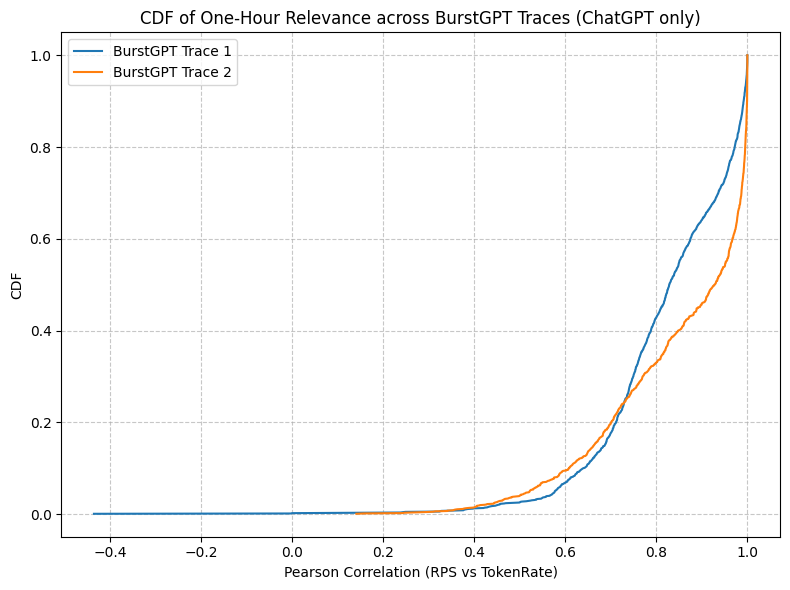

In [ ]:

# --- Plot CDF for BurstGPT ---
plt.figure(figsize=(8,6))
for relevances, label in [(relevances_burst1, "BurstGPT Trace 1"), (relevances_burst2, "BurstGPT Trace 2")]:
    values = np.sort(relevances)
    cdf = np.arange(1, len(values)+1) / len(values)
    plt.plot(values, cdf, label=label)

plt.xlabel("Pearson Correlation (RPS vs TokenRate)")
plt.ylabel("CDF")
plt.title(f"CDF of One-Hour Relevance across BurstGPT Traces ({MODEL_NAME} only)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

def load_trace_mooncake(file):
    # Read JSON lines
    df = pd.read_json(file, lines=True)

    # Rename to align with other loaders
    df.rename(columns={
        "input_length": "ContextTokens",
        "output_length": "GeneratedTokens",
        "timestamp": "TimeOffset"
    }, inplace=True)

    # Ensure numeric
    df["TimeOffset"] = pd.to_numeric(df["TimeOffset"], errors="coerce")

    # Drop NaNs if any
    df = df.dropna(subset=["TimeOffset", "ContextTokens", "GeneratedTokens"])

    return df

file_conv = "/mnt/network_drive/lrq/traces/mooncake/conversation_trace.jsonl"
file_synth = "/mnt/network_drive/lrq/traces/mooncake/synthetic_trace.jsonl"
file_tool = "/mnt/network_drive/lrq/traces/mooncake/toolagent_trace.jsonl"

df_conv = load_trace_mooncake(file_conv)
df_synth = load_trace_mooncake(file_synth)
df_tool = load_trace_mooncake(file_tool)

# Now reuse the same function as before
relevances_conv = compute_relevance_over_windows(df_conv, sample_size, time_window, label="Mooncake Conversation")
relevances_synth = compute_relevance_over_windows(df_synth, sample_size, time_window, label="Mooncake Synthetic")
relevances_tool = compute_relevance_over_windows(df_tool, sample_size, time_window, label="Mooncake ToolAgent")

Processing Mooncake Conversation: 100%|██████████| 982/982 [00:06<00:00, 145.94hour/s]


Minimum correlation for Mooncake Conversation in range [752400, 756000]: 0.7007


Processing Mooncake Synthetic: 100%|██████████| 283/283 [00:01<00:00, 145.34hour/s]


Minimum correlation for Mooncake Synthetic in range [147600, 151200]: 0.2318


Processing Mooncake ToolAgent: 100%|██████████| 982/982 [00:06<00:00, 144.31hour/s]

Minimum correlation for Mooncake ToolAgent in range [2952000, 2955600]: 0.8571


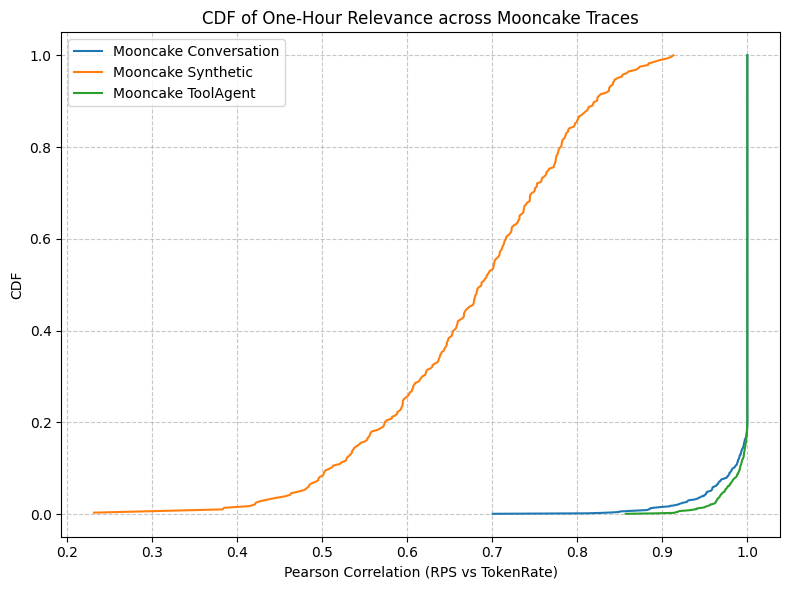

In [ ]:
plt.figure(figsize=(8,6))
for relevances, label in [
    (relevances_conv, "Mooncake Conversation"),
    (relevances_synth, "Mooncake Synthetic"),
    (relevances_tool, "Mooncake ToolAgent")
]:
    values = np.sort(relevances)
    cdf = np.arange(1, len(values)+1) / len(values)
    plt.plot(values, cdf, label=label)

plt.xlabel("Pearson Correlation (RPS vs TokenRate)")
plt.ylabel("CDF")
plt.title("CDF of One-Hour Relevance across Mooncake Traces")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

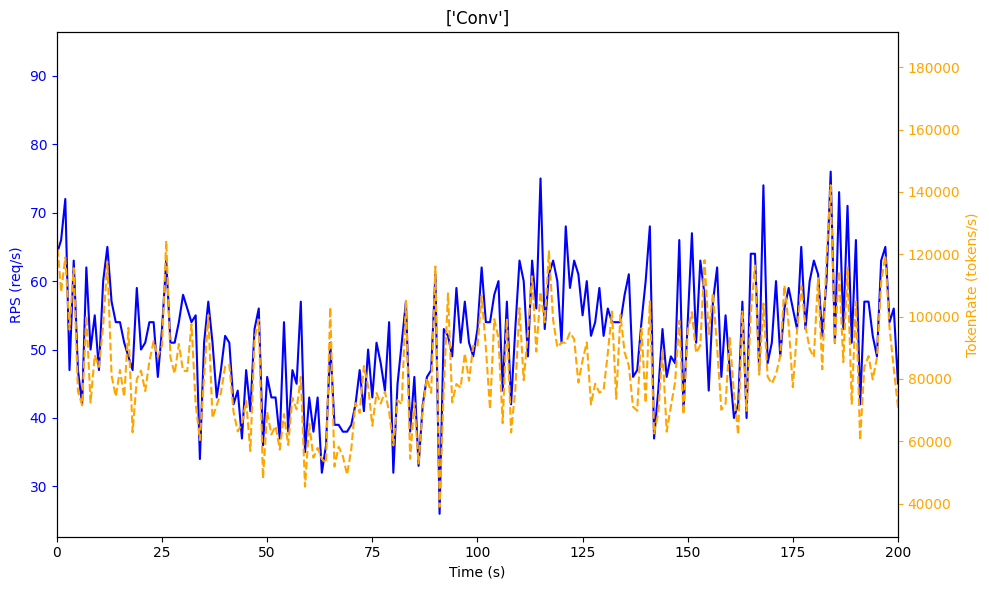

                          TIMESTAMP  ContextTokens  GeneratedTokens  \
0  2024-05-14 11:00:00.035598+00:00           3207              369   
1  2024-05-14 11:00:00.035682+00:00           2440                3   
2  2024-05-14 11:00:00.037704+00:00            609               22   
3  2024-05-14 11:00:00.155959+00:00           1546               23   
4  2024-05-14 11:00:00.156206+00:00            462               53   
5  2024-05-14 11:00:00.158483+00:00            747               91   
6  2024-05-14 11:00:00.163296+00:00            562               26   
7  2024-05-14 11:00:00.165772+00:00           2723              297   
8  2024-05-14 11:00:00.193243+00:00            566               26   
9  2024-05-14 11:00:00.195154+00:00           1169               13   
10 2024-05-14 11:00:00.245115+00:00            795               41   
11 2024-05-14 11:00:00.245156+00:00           2594               19   
12 2024-05-14 11:00:00.247144+00:00           2770                3   
13 202

In [5]:
time_window = 1
def filter_trace_by_range(df, start_time, end_time):
    """Filter the dataframe to only include entries within [start_time, end_time],
    and normalize TimeOffset to start from 0.
    """
    filtered_df = df[(df["TimeOffset"] >= start_time) & (df["TimeOffset"] < end_time)].copy()
    
    if not filtered_df.empty:
        filtered_df["TimeOffset"] -= filtered_df["TimeOffset"].iloc[0]
    
    return filtered_df

def plot_filtered_trace(df, title):
    plt.figure(figsize=(10, 6))
    
    # Aggregate for plotting
    df["Window"] = (df["TimeOffset"] // time_window) * time_window
    agg = df.groupby("Window").agg(
        RPS=("TimeOffset", "count"),
        TokenRate=("ContextTokens", "sum")
    ).reset_index()
    
    agg["RPS"] /= time_window
    agg["TokenRate"] /= time_window
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(agg["Window"], agg["RPS"], label="RPS", color="blue")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("RPS (req/s)", color="blue")
    ax1.tick_params(axis="y", colors="blue")
    ax1.set_title(title)
    
    # Right y-axis (TokenRate)
    ax2 = ax1.twinx()
    ax2.plot(agg["Window"], agg["TokenRate"], label="TokenRate", linestyle="--", color="orange")
    ax2.set_ylabel("TokenRate (tokens/s)", color="orange")
    ax2.tick_params(axis="y", colors="orange")
    plt.xlim(0,200)
    
    plt.tight_layout()
    plt.show()

import json
import random
from datetime import timedelta

def convert_df_to_json(df, json_file_path):
    """
    Convert a DataFrame into a JSON file with the following structure:
    - First entry: {"Content-Type": "application/json"}
    - Subsequent entries: requests built from DataFrame rows
    - Prompts are reproducible across runs (deterministic based on row index).
    """
    output = []
    
    # First entry
    output.append({"Content-Type": "application/json"})
    
    for idx, row in df.iterrows():
        # Deterministic seed per row ensures reproducibility across runs
        rnd = random.Random(idx)
        
        # Generate random prompt of integers
        prompt = [rnd.randint(0, 10000) for _ in range(int(row["ContextTokens"]))]
        
        # Format timestamp (row["TimeOffset"] in seconds → HH:MM:SS.microseconds)
        td = timedelta(seconds=float(row["TimeOffset"]))
        timestamp = str(td)
        if "." not in timestamp:
            timestamp += ".000000"  # ensure microseconds
        
        entry = {
            "data": {
                "model": "meta-llama/Llama-3.1-8B",
                "prompt": prompt,
                "temperature": 0,
                "stream": False,
                "max_tokens": int(row["GeneratedTokens"]),
                "min_tokens": int(row["GeneratedTokens"]),
            },
            "timestamp": timestamp,
        }
        output.append(entry)
    
    # Write to file
    with open(json_file_path, "w") as f:
        json.dump(output, f, indent=2)

# conv_filtered = filter_trace_by_range(df_conv, 0, 3600)  # First hour
# print(conv_filtered.head())

# burst_gpt_filtered_1 = filter_trace_by_range(df_burst1, 846000, 849600)  # First day
# burst_gpt_filtered_2 = filter_trace_by_range(df_burst2, 5029200, 5032800)  # First day
# mooncake_filtered = filter_trace_by_range(df_synth,147600, 151200)  # First hour

plot_filtered_trace(df_conv, ["Conv"])
print(df_conv.head(20))
# plot_filtered_trace(burst_gpt_filtered_1, ["BurstGPT Trace 1"])
# plot_filtered_trace(burst_gpt_filtered_2, ["BurstGPT Trace 2"])
# plot_filtered_trace(mooncake_filtered, ["Mooncake"])

# convert_df_to_json(burst_gpt_filtered_1, "/mnt/network_drive/lrq/traces/burst/burst_gpt_1.json")
# convert_df_to_json(burst_gpt_filtered_2, "/mnt/network_drive/lrq/traces/burst/burst_gpt_2.json")
# convert_df_to_json(mooncake_filtered, "/mnt/network_drive/lrq/traces/mooncake/mooncake.json")



In [1]:
import pandas as pd

def load_and_analyze_traces(file_code, file_conv):
    # Load the two CSV files
    df_code = pd.read_csv(file_code)
    df_conv = pd.read_csv(file_conv)

    # Concatenate them
    df = pd.concat([df_code, df_conv], ignore_index=True)

    # Compute averages
    avg_context = df["ContextTokens"].mean()
    avg_generated = df["GeneratedTokens"].mean()

    # Print results
    print(f"Average ContextTokens: {avg_context:.2f}")
    print(f"Average GeneratedTokens: {avg_generated:.2f}")

    return avg_context, avg_generated


# Example usage
file_code = "/mnt/network_drive/lrq/traces/AzureLLMInferenceTrace_code_1week.csv"
file_conv = "/mnt/network_drive/lrq/traces/AzureLLMInferenceTrace_conv_1week.csv"

load_and_analyze_traces(file_code, file_conv)

Average ContextTokens: 1966.72
Average GeneratedTokens: 73.96


(np.float64(1966.7171194894024), np.float64(73.9574835175015))